In [28]:
from typing import TypedDict, Annotated
from langgraph.graph import END, START, StateGraph, add_messages
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode
from langgraph.checkpoint.memory import MemorySaver


memory= MemorySaver()
load_dotenv()
search_tool = TavilySearchResults(max_results=2)
tools= [search_tool]
llm = ChatGroq(model="llama3-70b-8192") 

llm_with_search = llm.bind_tools(tools=tools)


In [29]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]

def chatbot(state:AgentState)-> AgentState:
    return {
        "messages":[llm_with_search.invoke(state['messages'])]
    }

def node_router(state:AgentState)->str:
    last_message = state['messages'][-1]

    if(hasattr(last_message,"tool_calls") and len(last_message.tool_calls) >0):
        return "tools call"
    else:
        return "stop"
tool_node = ToolNode(tools=tools)

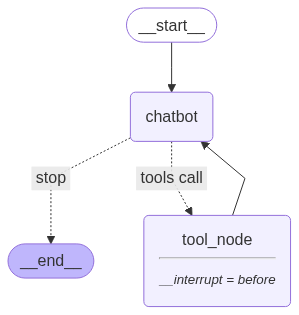

In [30]:
graph= StateGraph(AgentState)

graph.add_node("chatbot", chatbot)
graph.add_node("tool_node", tool_node)

graph.add_edge(START, "chatbot")
graph.add_conditional_edges(
    "chatbot",
    node_router,
    {
        "tools call":"tool_node",
        "stop":END
    }
)
graph.add_edge("tool_node","chatbot")

app = graph.compile(checkpointer=memory, interrupt_before=["tool_node"])

app

In [31]:
config = {
    "configurable":{
        "thread_id": 1
    }
}

events = app.stream({
    "messages":[HumanMessage(content="Give 3 Latest politics news out of Nigeria today")]
}, config=config,
  stream_mode="values"
  
)

for event in events:
    event["messages"][-1].pretty_print()



================================ Human Message =================================

Give 3 Latest politics news out of Nigeria today
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (p3nwacvmv)
 Call ID: p3nwacvmv
  Args:
    query: latest politics news nigeria


In [32]:
app.get_state(config=config).next

('tool_node',)

In [33]:
events = app.stream(None, config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (p3nwacvmv)
 Call ID: p3nwacvmv
  Args:
    query: latest politics news nigeria
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Nigeria politics - BBC News Pidgin", "url": "https://www.bbc.com/pidgin/topics/c95y35z683nt", "content": "Mohammadu Buhari waves to the crowd during his swearing in ceremony in Abuja, Nigeria Capital, May 29, 2015.\n\n## Former Nigerian President Buhari begin final journey home\n\nMonday Okpehbolo\n\n## Supreme Court confam Monday Okpebholo as elected govnor of Edo State\n\nFoto of FCT Minister Nyesom Wike and opposition politician, Peter Obi\n\n## 'Peter Obi no go ever be president' - Wike\n\nSenator Natasha Akpoti-Uduaghan\n\n## Court tell Senate to recall Senator Natasha Akpoti-Uduaghan to kontinu her work [...] Natasha Akpoti Uduaghan for di FCT High Court, M

In [20]:
from IPython.display import display, Markdown
display(Markdown(result["messages"][-1].content))

Here are three latest politics news out of Nigeria today:

1. The All Progressives Congress (APC) has announced its plan to hold a stakeholders' meeting to resolve the ongoing crisis rocking the party in Lagos State. This comes after a faction of the party had earlier rejected the list of candidates submitted by the party's national leadership.

2. The Peoples Democratic Party (PDP) has accused the ruling All Progressives Congress (APC) of plotting to rig the 2027 general elections. The opposition party alleged that the APC is planning to compromise the electoral process by infiltrating the Independent National Electoral Commission (INEC) with its loyalists.

3. The Nigerian Senate has begun an investigation into the alleged mismanagement of N1.5 trillion budgeted for the Niger Delta Development Commission (NDDC) between 2015 and 2020. The investigation follows a petition by a group of Niger Delta stakeholders accusing the NDDC of financial recklessness and mismanagement.